## Preparing Training DATA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.animation as animation
import scipy.stats as stats
from sklearn import linear_model

In [2]:
def Solve_RK4(t, X_initial, func_ODEs, h):
    n = t.shape[0]
    X = X_initial

    for i in range(n-1):
        
        midt = t[i] + 0.5*h

        k1 = func_ODEs(t[i], X)

        midX1 = X + k1*0.5*h
        k2 = func_ODEs(midt, midX1)

        midX2 = X + k2*0.5*h
        k3 = func_ODEs(midt, midX2)

        X3 = X + k3*h
        k4 = func_ODEs(t[i+1], X3)

        X = X + (k1 + 2*k2 + 2*k3 + k4)*h/6

    return X

def func_ODEs(t, X):
    a = 0.25
    b = 4.0
    F = 8.0
    G = 1.25
    
    x = X[0, :]
    y = X[1, :]
    z = X[2, :]
    rho = X[3, :]
    dx_dt = -y**2 - z**2 - a*x + a*F
    dy_dt = x*y - b*x*z - y + G
    dz_dt = b*x*y + x*z - z
    drho_dt = -rho*(-a + 2*x - 2)
    ODEs = np.array([dx_dt, dy_dt, dz_dt, drho_dt])

    return ODEs

def PDF(X, mu, cov):
    return stats.multivariate_normal(mean=mu, cov=cov).pdf(X.T)

def ensemble(X, dx, memb, size, mu, cov):
    X_memb_ini = np.array([[np.random.choice(np.linspace(X[0, i]-dx, X[0, i]+dx, 2*memb), memb) for i in range(size)], [np.random.choice(np.linspace(X[1, i]-dx, X[1, i]+dx, 2*memb), memb) for i in range(size)], [np.random.choice(np.linspace(X[2, i]-dx, X[2, i]+dx, 2*memb), memb) for i in range(size)]])
    rho_memb_ini = PDF(X_memb_ini, mu, cov)

    x_memb_ini = X_memb_ini[0, :, :].reshape(size*memb)
    y_memb_ini = X_memb_ini[1, :, :].reshape(size*memb)
    z_memb_ini = X_memb_ini[2, :, :].reshape(size*memb)
    rho_memb_ini = rho_memb_ini.reshape(size*memb)
    ini_array_memb = np.vstack((x_memb_ini, y_memb_ini, z_memb_ini, rho_memb_ini))

    return ini_array_memb, x_memb_ini, y_memb_ini, z_memb_ini

In [3]:
training_size = 1

mu = np.array([0, 0, 0])
cov = np.diag([1, 1, 1])

dt = 0.02
dx = 0.2
dim = 3
t = np.arange(0, 10000*dt, dt)

X_ini_train = np.array([[0], [0], [0]])
rho_ini_train = PDF(X_ini_train, mu, cov)

nt = t.shape[0]

x_nume_train = np.zeros((nt, training_size))
y_nume_train = np.zeros((nt, training_size))
z_nume_train = np.zeros((nt, training_size))
rho_nume_train = np.zeros((nt, training_size))

In [4]:
x_nume_train[0, :] = X_ini_train[0, :]
y_nume_train[0, :] = X_ini_train[1, :]
z_nume_train[0, :] = X_ini_train[2, :]
rho_nume_train[0, :] = rho_ini_train
ini_array_nume_train = np.vstack((X_ini_train, rho_ini_train))

for i in range(nt-1):

    # calculate X

    x_nume_train[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_train, func_ODEs, dt)[0, :]
    y_nume_train[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_train, func_ODEs, dt)[1, :]
    z_nume_train[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_train, func_ODEs, dt)[2, :]
    rho_nume_train[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_train, func_ODEs, dt)[3, :]
    ini_array_nume_train = np.array([x_nume_train[i+1, :], y_nume_train[i+1, :], z_nume_train[i+1, :], rho_nume_train[i+1, :]])

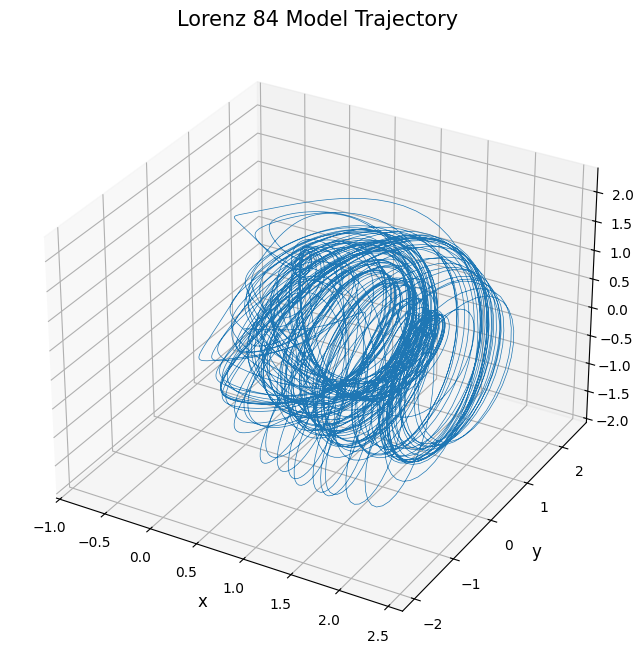

In [34]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.plot(x_nume_train[:, 0], y_nume_train[:, 0], z_nume_train[:, 0], lw=0.5)
ax.set_title("Lorenz 84 Model Trajectory", fontsize=15)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_zlabel("z", fontsize=12)

plt.savefig('Lorenz84_trajectory.png', dpi=500)
plt.show()

## Training with the first 7000 (max) steps

In [6]:
from Reservoir_Computing import reservoir


# Dictionary the models 
# d is used to save the pre-trained models
# 100 different models are saved for the following prediction task
model_size = 100 # how many different models are trained 
d          = {}
count      = 0 
# stack data
data               = np.array(np.vstack((x_nume_train[:, 0], y_nume_train[:, 0], z_nume_train[:, 0])))
dim_var, dim_time  = data.shape

while True:
    a                  = np.random.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 1, replace=False) # leaking rate 
    data_length        = np.random.choice(range(5000,7000), 1, replace=False)                      # [5000,7000] steps as the minimum/maximum length for traning the model
    resSize            = np.random.choice(range(50,100), 1,  replace=False)                        # reservoir size (bigger leads to more complicated model)  
    validLen           = 10                                                                        # using the subsequent 10 steps for validation. e.g., training ends at 500, then use 501-510 for validation
    initLen            = 10 
    model              = reservoir(trainLen= int(data_length), validLen= validLen, initLen= initLen, inSize=int(dim_var), outSize = int(dim_var),
                                   resSize = int(resSize),           a = a,          seed = 0,
                                       reg = 1e1)
    Y, x_record, Win, W, Wout,mse   = model.training_validation(data.T)

    if (np.mean(mse[:3]) < 0.02) & (count<model_size):  
        # To keep a model, the mean MSE (x,y and z) at the validation set should be smaller than 0.02 
        d["model{0}".format(count)]    = model, Win, W, Wout, "a="+str(a), "resSize="+str(resSize), "testLen="+str(validLen)  
        count = count+1
        print(count)
        print(np.mean(mse[:3]))
    elif count>=model_size:
        break

C:\Users\kylec\AppData\Local\Temp\ipykernel_11084\2688635574.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model              = reservoir(trainLen= int(data_length), validLen= validLen, initLen= initLen, inSize=int(dim_var), outSize = int(dim_var),
C:\Users\kylec\AppData\Local\Temp\ipykernel_11084\2688635574.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  resSize = int(resSize),           a = a,          seed = 0,


1
0.0009509467929913036
2
0.002295701569667552
3
0.019023536445634332
4
0.0007882647999335244
5
0.004198718915590846
6
0.009832148929409716
7
0.0005858516759789841
8
0.0005679114319192573
9
0.0005844387239300635
10
0.005027458922684928
11
0.003594328282114327
12
0.006611396857587337
13
0.0012636403959626254
14
0.0013922697875049194
15
0.00011260245790170359
16
0.0018031809910253153
17
0.013008481014314557
18
0.007768727201009191
19
0.004382801416888282
20
0.006170310663981116
21
0.0009045943008850584
22
0.0005935274422112545
23
0.0007149737712709896
24
0.0014116473244485687
25
0.002118838062858725
26
0.011384013691513824
27
0.013538791495244134
28
0.002767002669977935
29
0.00018686835075975073
30
0.00019994455155214596
31
0.0008797423856003616
32
0.0004667643700905783
33
0.0013795257765624926
34
0.0011654186165316416
35
0.003374924863066415
36
0.001044113009891816
37
0.000963832258392763
38
0.00245111667254001
39
0.005960987009788178
40
0.0018361417978649322
41
0.004704702093161725
42


In [7]:
x_nume_test = np.zeros((nt, training_size))
y_nume_test = np.zeros((nt, training_size))
z_nume_test = np.zeros((nt, training_size))
rho_nume_test = np.zeros((nt, training_size))

X_ini_test = np.array([[0], [1], [0]])
rho_ini_test = PDF(X_ini_test, mu, cov)

x_nume_test[0, :] = X_ini_test[0, :]
y_nume_test[0, :] = X_ini_test[1, :]
z_nume_test[0, :] = X_ini_test[2, :]
rho_nume_test[0, :] = rho_ini_test
ini_array_nume_test = np.vstack((X_ini_test, rho_ini_test))

for i in range(nt-1):

    # calculate X

    x_nume_test[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_test, func_ODEs, dt)[0, :]
    y_nume_test[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_test, func_ODEs, dt)[1, :]
    z_nume_test[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_test, func_ODEs, dt)[2, :]
    rho_nume_test[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume_test, func_ODEs, dt)[3, :]
    ini_array_nume_test = np.array([x_nume_test[i+1, :], y_nume_test[i+1, :], z_nume_test[i+1, :], rho_nume_test[i+1, :]])

data_test = np.vstack((x_nume_test[:, 0], y_nume_test[:, 0], z_nume_test[:, 0]))

## Testing results

In [8]:
# initial time: t=100 (the last step of training data)
# forecast time: 1251
# for each model, we generate 1000 ensembles 

forecast_time = 1252
ensemble_size = 1000 
predict       = np.zeros((dim, model_size, ensemble_size, forecast_time))
for count in range(model_size):
    Win  = d["model{0}".format(count)][1]
    W    = d["model{0}".format(count)][2]
    Wout = d["model{0}".format(count)][3] 
    out  = d["model{0}".format(count)][0].prediction(data_test[:, :101].T,Win,W,Wout,ensemble_size=ensemble_size,forecast_time=forecast_time)
    predict[:, count, :, :] = out 

In [9]:
R_square = np.zeros((dim, model_size))

for i in range(dim):
    for j in range(model_size):
        slope, intercept, r_value, p_value, std_err = stats.linregress(data_test[i, 100:201], predict[i, j, 0, :101])
        R_square[i, j] = r_value**2

R_square_mean = np.mean(R_square, axis=0)
k = np.argsort(R_square_mean)[::-1]

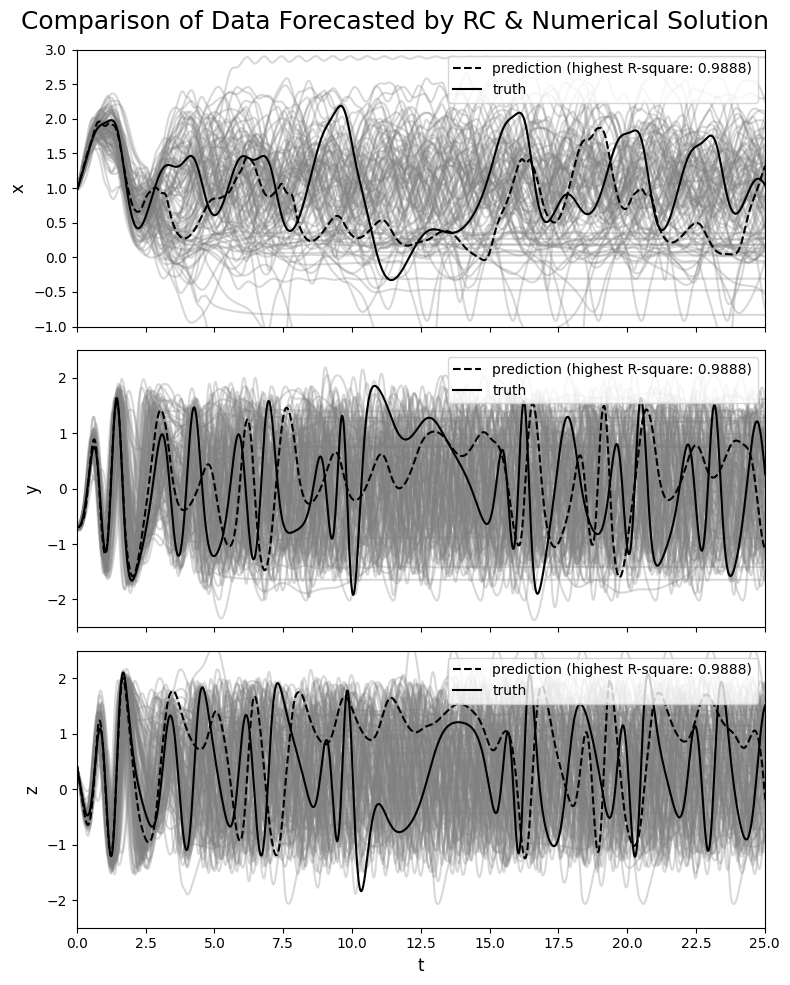

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex='all')

for i in range(dim):
    ax[i].plot(t[:forecast_time], predict[i, :, 0, :].T, 'gray', alpha=0.3)
    ax[i].plot(t[:forecast_time], predict[i, k[0], 0, :], 'k--', label='prediction (highest R-square: %.4f)' %R_square_mean[k[0]])
    ax[i].plot(t[:forecast_time], data_test[i, 100:forecast_time+100], 'k', label='truth')
    ax[i].legend(loc='upper right', fontsize=10)

ax[0].set_ylim([-1, 3])
ax[0].set_ylabel('x', fontsize=12)
ax[1].set_ylim([-2.5, 2.5])
ax[1].set_ylabel('y', fontsize=12)
ax[2].set_ylim([-2.5, 2.5])
ax[2].set_ylabel('z', fontsize=12)


ax[2].set_xticks(np.linspace(0, t[forecast_time-2], 11))
ax[2].set_xlim([0, t[forecast_time-2]])
ax[2].set_xlabel('t', fontsize=12)

plt.suptitle('Comparison of Data Forecasted by RC & Numerical Solution', fontsize=18)

plt.tight_layout()
plt.savefig('Lorenz84_models.png', dpi=500)
plt.show()

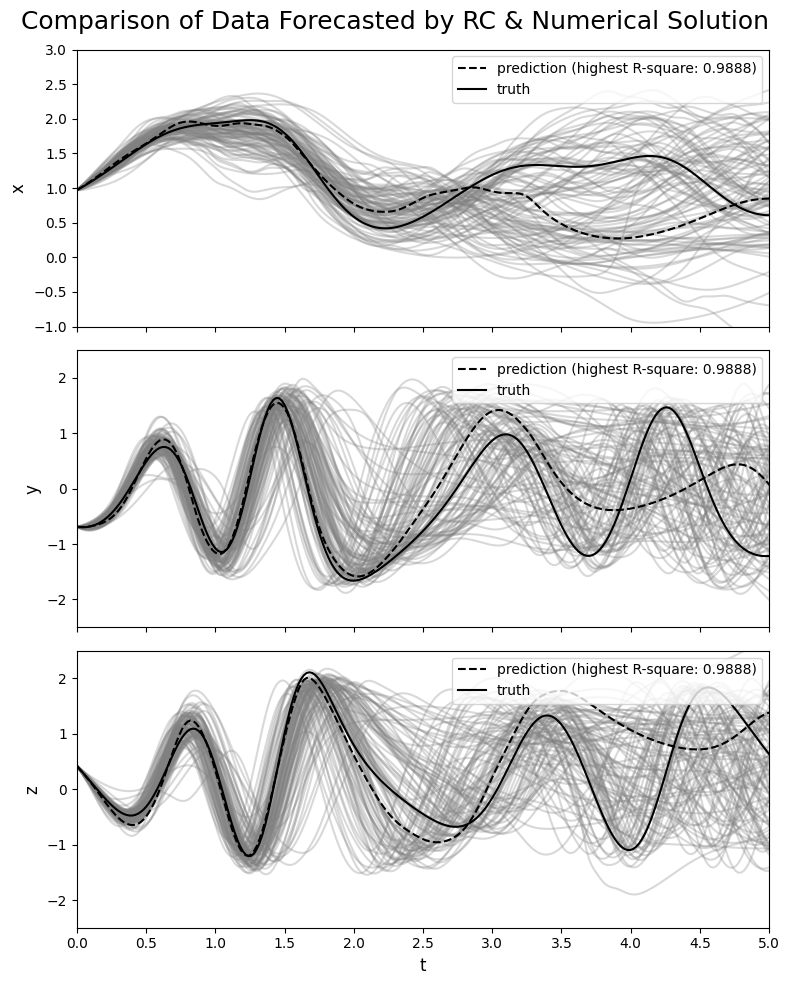

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex='all')

for i in range(dim):
    ax[i].plot(t[:forecast_time], predict[i, :, 0, :].T, 'gray', alpha=0.3)
    ax[i].plot(t[:forecast_time], predict[i, k[0], 0, :], 'k--', label='prediction (highest R-square: %.4f)' %R_square_mean[k[0]])
    ax[i].plot(t[:forecast_time], data_test[i, 100:forecast_time+100], 'k', label='truth')
    ax[i].legend(loc='upper right', fontsize=10)

ax[0].set_ylim([-1, 3])
ax[0].set_ylabel('x', fontsize=12)
ax[1].set_ylim([-2.5, 2.5])
ax[1].set_ylabel('y', fontsize=12)
ax[2].set_ylim([-2.5, 2.5])
ax[2].set_ylabel('z', fontsize=12)


ax[2].set_xticks(np.linspace(0, 5, 11))
ax[2].set_xlim([0, 5])
ax[2].set_xlabel('t', fontsize=12)

plt.suptitle('Comparison of Data Forecasted by RC & Numerical Solution', fontsize=18)

plt.tight_layout()
plt.savefig('Lorenz84_models_detailed.png', dpi=500)
plt.show()

## Analog Forecast

In [12]:
analog_rate = 0.05

memb = int((forecast_time - 1) * analog_rate)

data_RC = predict[:, k[0], :, :]

G_RC = np.zeros((forecast_time-1, ensemble_size, dim, dim))
X_memb_ini = np.zeros((dim, ensemble_size, memb))
X_memb_fin = np.zeros((dim, ensemble_size, memb))

for i in range(forecast_time-1):

    # calculate G

    for j in range(ensemble_size):

        dist = np.sqrt((data_RC[0, j, :-1] - data_RC[0, j, i])**2 + (data_RC[1, j, :-1] - data_RC[1, j, i])**2 + (data_RC[2, j, :-1] - data_RC[2, j, i])**2)
        analog = np.argsort(dist)
        X_memb_ini[:, j, :] = data_RC[:, j, analog[:memb]]
        X_memb_fin[:, j, :] = data_RC[:, j, analog[:memb]+1]

        if dim == 1:
            Ga = np.dot(X_memb_fin[:, j, :], X_memb_ini[:, j, :].transpose())
            Gb = np.linalg.inv(np.array([[np.dot(X_memb_ini[:, j, :], X_memb_ini[:, j, :].transpose())]]))
            G_RC[i, j, :, :] = np.dot(Ga, Gb)
        else:
            Ga = np.dot(X_memb_fin[:, j, :], X_memb_ini[:, j, :].transpose())
            Gb = np.linalg.inv(np.dot(X_memb_ini[:, j, :], X_memb_ini[:, j, :].transpose()))
            G_RC[i, j, :, :] = np.dot(Ga, Gb)

In [13]:
abs_detG_RC = abs(np.linalg.det(G_RC))
abs_detG_RC_avg = np.mean(abs_detG_RC, axis=0)
norm_abs_detG_RC = stats.zscore(abs_detG_RC, axis=0, ddof=1)

In [14]:
mu = np.array([data_RC[0, 0, 0], data_RC[1, 0, 0], data_RC[2, 0, 0]])
cov = np.diag([0.05, 0.05, 0.05])

rho_RC = np.zeros((forecast_time, ensemble_size))

rho_ini_RC = PDF(data_RC[:, :, 0], mu, cov)
rho_RC[0, :] = rho_ini_RC

for i in range(forecast_time-1):
    rho_RC[i+1, :] = rho_RC[i, :] / abs_detG_RC[i, :]

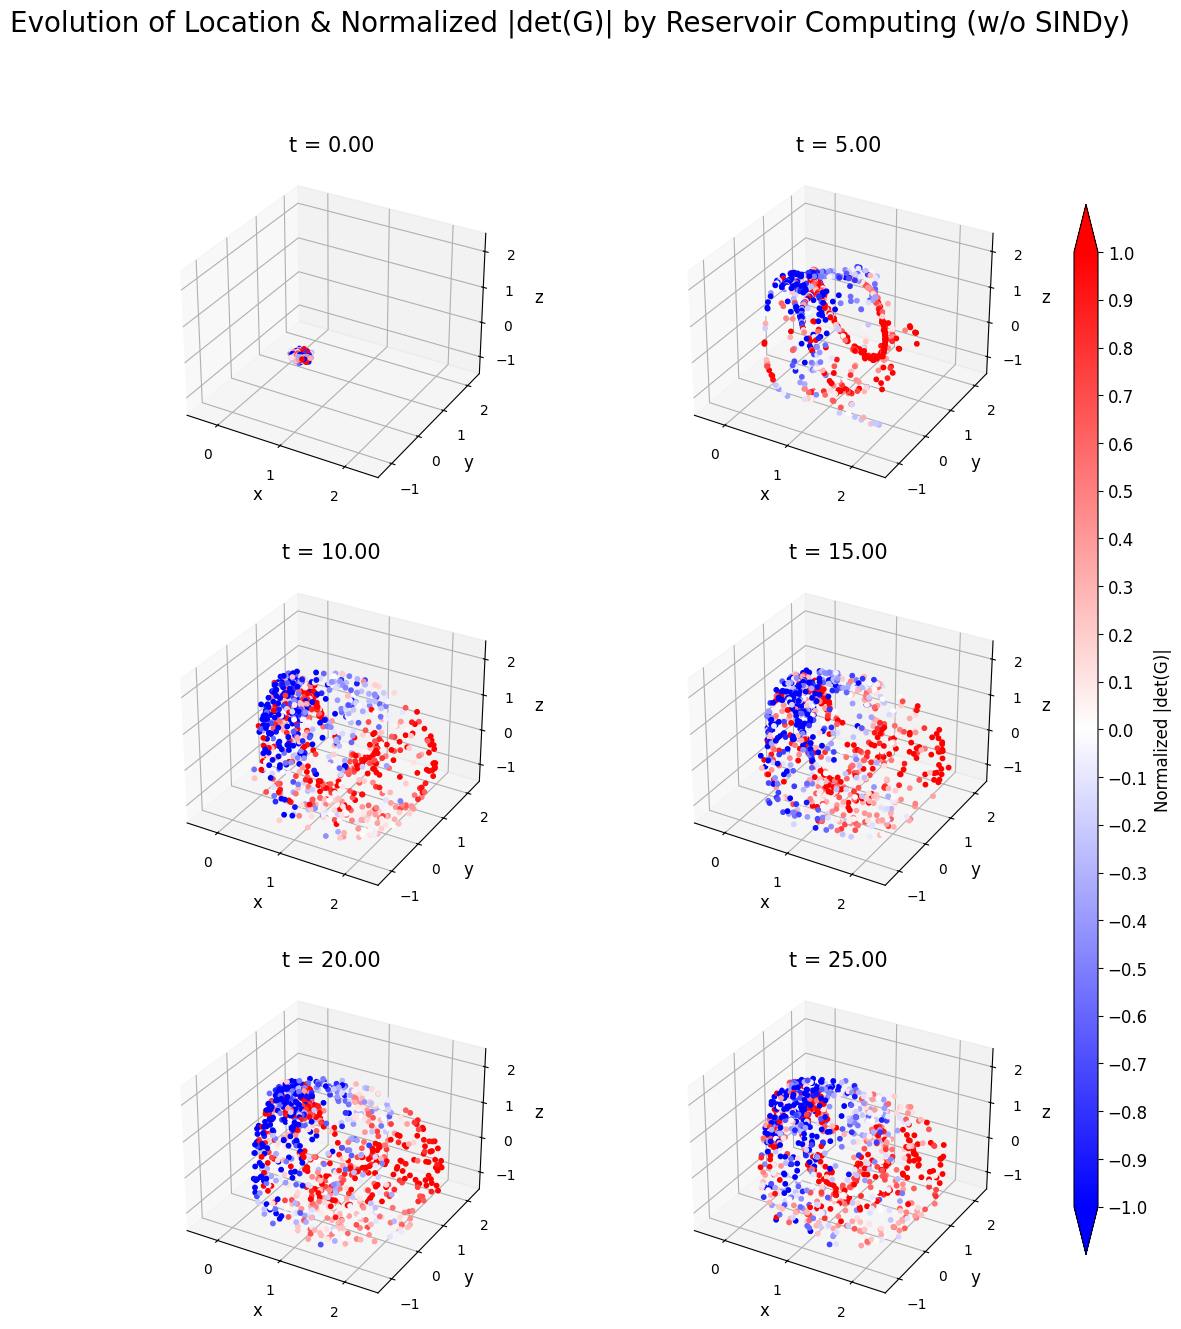

In [15]:
norm = plt.Normalize(-1, 1)

fig, ax = plt.subplots(3, 2, figsize=(12, 15), subplot_kw={'projection': '3d'})

for i in range(3):
    for j in range(2):
        sc = ax[i, j].scatter(data_RC[0, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[1, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[2, :, int(((forecast_time-2) / 5) * (2*i+j))], c=norm_abs_detG_RC[int(((forecast_time-2) / 5) * (2*i+j)), :].T, cmap='bwr', norm=norm, s=10, alpha=1)
        ax[i, j].set_xticks(np.linspace(0, 2, 3))
        ax[i, j].set_yticks(np.linspace(-1, 2, 4))
        ax[i, j].set_zticks(np.linspace(-1, 2, 4))
        ax[i, j].set_xlim([-0.5, 2.5])
        ax[i, j].set_ylim([-1.5, 2.5])
        ax[i, j].set_zlim([-1.5, 2.5])
        ax[i, j].set_xlabel("x", fontsize=12)
        ax[i, j].set_ylabel("y", fontsize=12)
        ax[i, j].set_zlabel("z", fontsize=12)
        ax[i, j].set_title('t = %.2f' %t[int(((forecast_time-2) / 5) * (2*i+j))], fontsize=15)
        ax[i, j].grid()
        #ax[i, j].view_init(elev=15, azim=-60)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.linspace(-1, 1, 21), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Normalized |det(G)|', fontsize=12)

#plt.tight_layout()
plt.suptitle('Evolution of Location & Normalized |det(G)| by Reservoir Computing (w/o SINDy)', fontsize=20)
plt.savefig('Lorenz84_det(G)_RC.png', dpi=500)
plt.show()

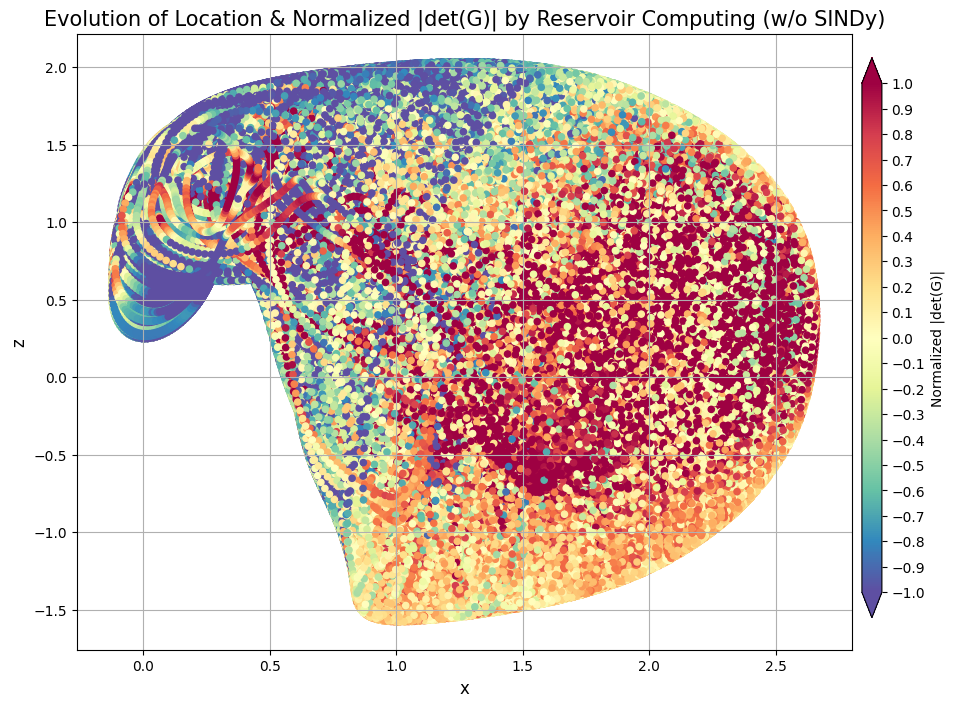

In [16]:
norm = plt.Normalize(-1, 1)

fig = plt.figure(figsize=(10, 8))

sc = plt.scatter(data_RC[0, :, :-1], data_RC[2, :, :-1], c=norm_abs_detG_RC.T, cmap='Spectral_r', norm=norm, s=20, alpha=1)
#plt.xticks(np.linspace(-0.5, 2.5, 7))
#plt.yticks(np.linspace(-1.5, 2.5, 9))
#plt.xlim([-0.5, 2.5])
#plt.ylim([-1.5, 2.5])
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.title('Evolution of Location & Normalized |det(G)| by Reservoir Computing (w/o SINDy)', fontsize=15)
plt.grid()

cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.linspace(-1, 1, 21), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Normalized |det(G)|', fontsize=10)

#plt.tight_layout()
plt.savefig('Lorenz84_xz_det(G)_RC.png', dpi=500)
plt.show()

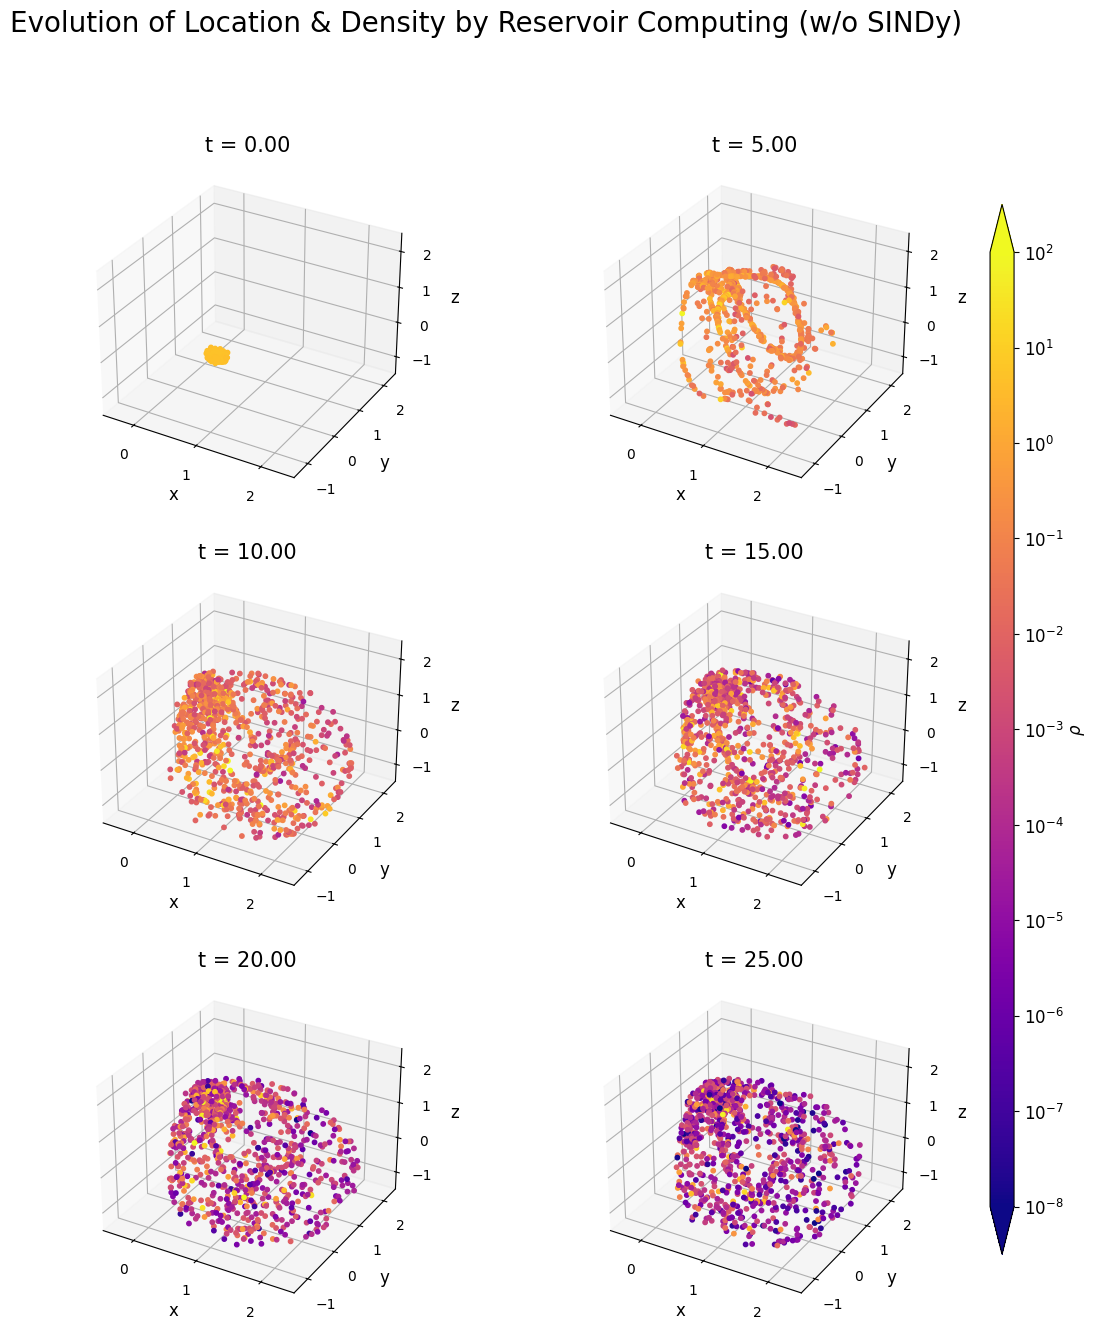

In [17]:
norm = colors.LogNorm(vmin=1e-8, vmax=1e2)

fig, ax = plt.subplots(3, 2, figsize=(12, 15), subplot_kw={'projection': '3d'})

for i in range(3):
    for j in range(2):
        sc = ax[i, j].scatter(data_RC[0, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[1, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[2, :, int(((forecast_time-2) / 5) * (2*i+j))], c=rho_RC[int(((forecast_time-2) / 5) * (2*i+j)), :].T, cmap='plasma', norm=norm, s=10, alpha=1)
        ax[i, j].set_xticks(np.linspace(0, 2, 3))
        ax[i, j].set_yticks(np.linspace(-1, 2, 4))
        ax[i, j].set_zticks(np.linspace(-1, 2, 4))
        ax[i, j].set_xlim([-0.5, 2.5])
        ax[i, j].set_ylim([-1.5, 2.5])
        ax[i, j].set_zlim([-1.5, 2.5])
        ax[i, j].set_xlabel("x", fontsize=12)
        ax[i, j].set_ylabel("y", fontsize=12)
        ax[i, j].set_zlabel("z", fontsize=12)
        ax[i, j].set_title('t = %.2f' %t[int(((forecast_time-2) / 5) * (2*i+j))], fontsize=15)
        ax[i, j].grid()
        #ax[i, j].view_init(elev=15, azim=-60)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.logspace(-8, 2, 11), extend='both', aspect = 40)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\rho$', fontsize=12)

#plt.tight_layout()
plt.suptitle('Evolution of Location & Density by Reservoir Computing (w/o SINDy)', fontsize=20)
plt.savefig('Lorenz84_rho_RC.png', dpi=500)
plt.show()

In [19]:
abs_detG_SINDy = np.zeros((forecast_time-1, ensemble_size))

for i in range(forecast_time-2, -1, -1):
    ##### calculate divergence of f(x) #### 

    # using 2nd order polynomial for SINDy bias correction
    x_predictor = np.squeeze(np.array([np.ones(ensemble_size), data_RC[0, :, i], data_RC[1, :, i], data_RC[2, :, i], data_RC[0, :, i]**2, data_RC[1, :, i]**2, data_RC[2, :, i]**2, data_RC[0, :, i]*data_RC[1, :, i], data_RC[1, :, i]*data_RC[2, :, i], data_RC[0, :, i]*data_RC[2, :, i]]))

    if i == forecast_time-2:  
        clf = linear_model.Lasso(alpha=0.01, fit_intercept=False)
        clf.fit(x_predictor.T, abs_detG_RC[i, :])

    abs_detG_SINDy[i, :] = np.dot(clf.coef_.T, x_predictor)

abs_detG_SINDy_avg = np.mean(abs_detG_SINDy, axis=0)
norm_abs_detG_SINDy = stats.zscore(abs_detG_SINDy, axis=0, ddof=1)

In [20]:
mu = np.array([data_RC[0, 0, 0], data_RC[1, 0, 0], data_RC[2, 0, 0]])
cov = np.diag([0.05, 0.05, 0.05])

rho_SINDy = np.zeros((forecast_time, ensemble_size))

rho_ini_SINDy = PDF(data_RC[:, :, 0], mu, cov)
rho_SINDy[0, :] = rho_ini_SINDy

for i in range(forecast_time-1):
    rho_SINDy[i+1, :] = rho_SINDy[i, :] / abs_detG_SINDy[i, :]

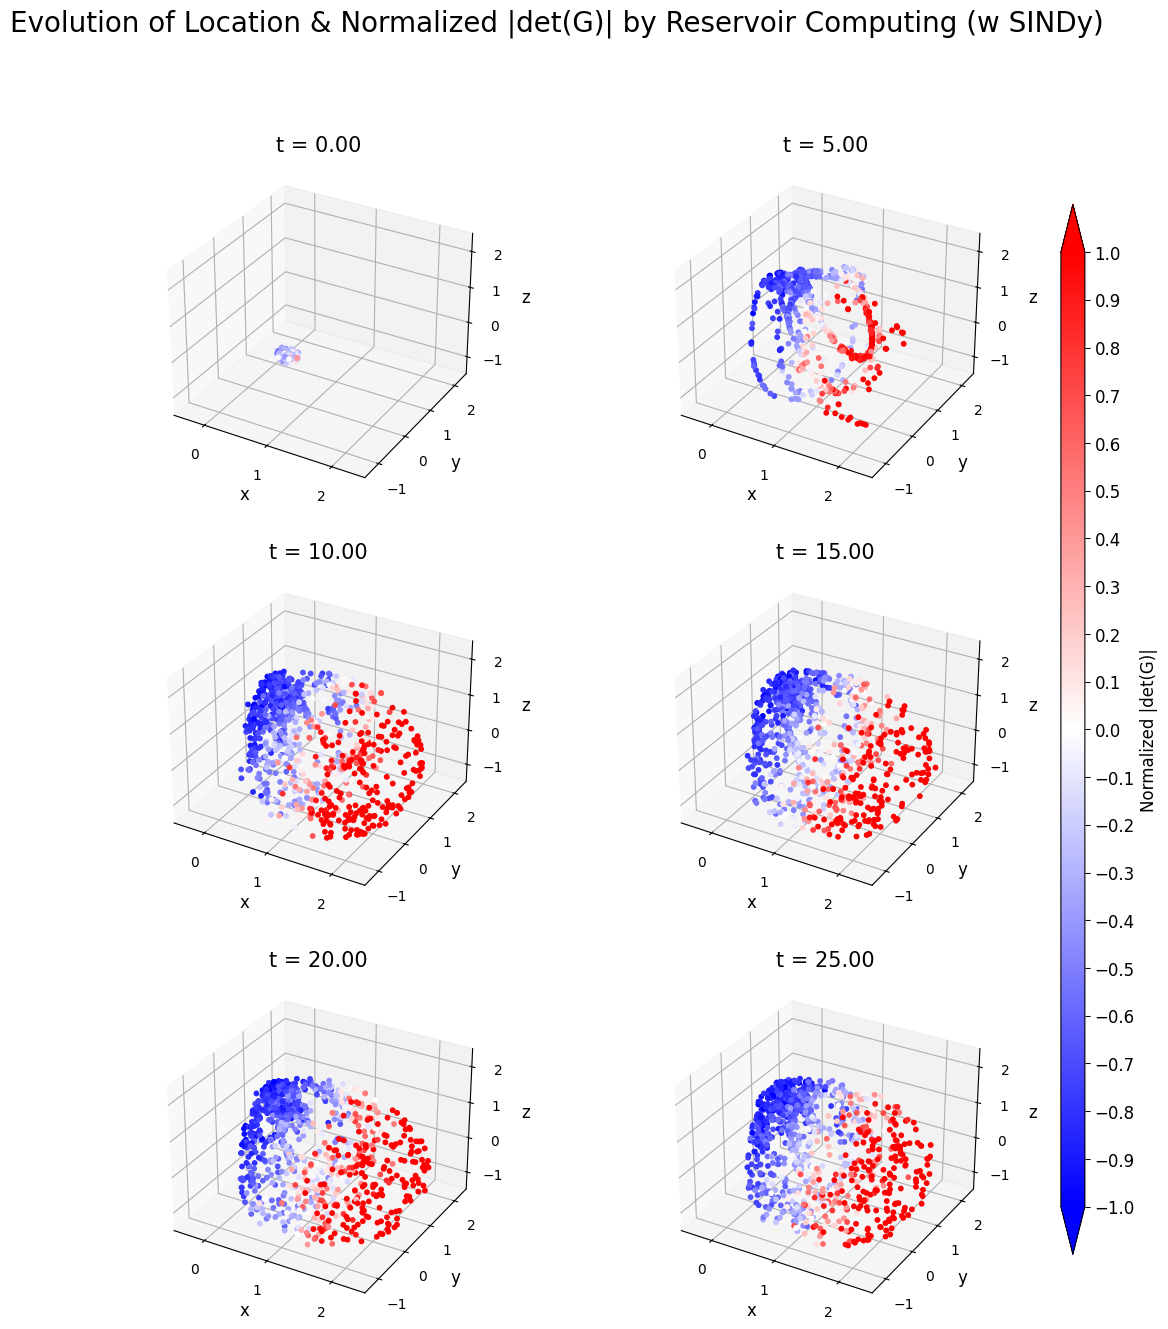

In [21]:
norm = plt.Normalize(-1, 1)

fig, ax = plt.subplots(3, 2, figsize=(12, 15), subplot_kw={'projection': '3d'})

for i in range(3):
    for j in range(2):
        sc = ax[i, j].scatter(data_RC[0, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[1, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[2, :, int(((forecast_time-2) / 5) * (2*i+j))], c=norm_abs_detG_SINDy[int(((forecast_time-2) / 5) * (2*i+j)), :].T, cmap='bwr', norm=norm, s=10, alpha=1)
        ax[i, j].set_xticks(np.linspace(0, 2, 3))
        ax[i, j].set_yticks(np.linspace(-1, 2, 4))
        ax[i, j].set_zticks(np.linspace(-1, 2, 4))
        ax[i, j].set_xlim([-0.5, 2.5])
        ax[i, j].set_ylim([-1.5, 2.5])
        ax[i, j].set_zlim([-1.5, 2.5])
        ax[i, j].set_xlabel("x", fontsize=12)
        ax[i, j].set_ylabel("y", fontsize=12)
        ax[i, j].set_zlabel("z", fontsize=12)
        ax[i, j].set_title('t = %.2f' %t[int(((forecast_time-2) / 5) * (2*i+j))], fontsize=15)
        ax[i, j].grid()
        #ax[i, j].view_init(elev=15, azim=-60)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.linspace(-1, 1, 21), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Normalized |det(G)|', fontsize=12)

#plt.tight_layout()
plt.suptitle('Evolution of Location & Normalized |det(G)| by Reservoir Computing (w SINDy)', fontsize=20)
plt.savefig('Lorenz84_det(G)_SINDy.png', dpi=500)
plt.show()

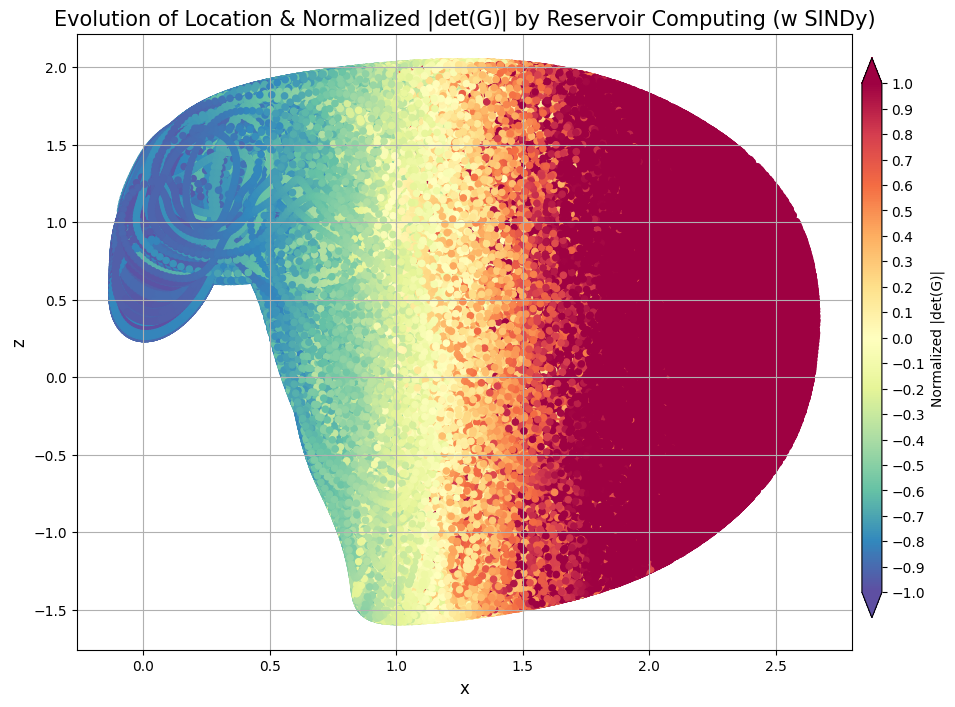

In [22]:
norm = plt.Normalize(-1, 1)

fig = plt.figure(figsize=(10, 8))

sc = plt.scatter(data_RC[0, :, :-1], data_RC[2, :, :-1], c=norm_abs_detG_SINDy.T, cmap='Spectral_r', norm=norm, s=20, alpha=1)
#plt.xticks(np.linspace(-0.5, 2.5, 7))
#plt.yticks(np.linspace(-1.5, 2.5, 9))
#plt.xlim([-0.5, 2.5])
#plt.ylim([-1.5, 2.5])
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.title('Evolution of Location & Normalized |det(G)| by Reservoir Computing (w SINDy)', fontsize=15)
plt.grid()

cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.linspace(-1, 1, 21), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Normalized |det(G)|', fontsize=10)

#plt.tight_layout()
plt.savefig('Lorenz84_xz_det(G)_SINDy.png', dpi=500)
plt.show()

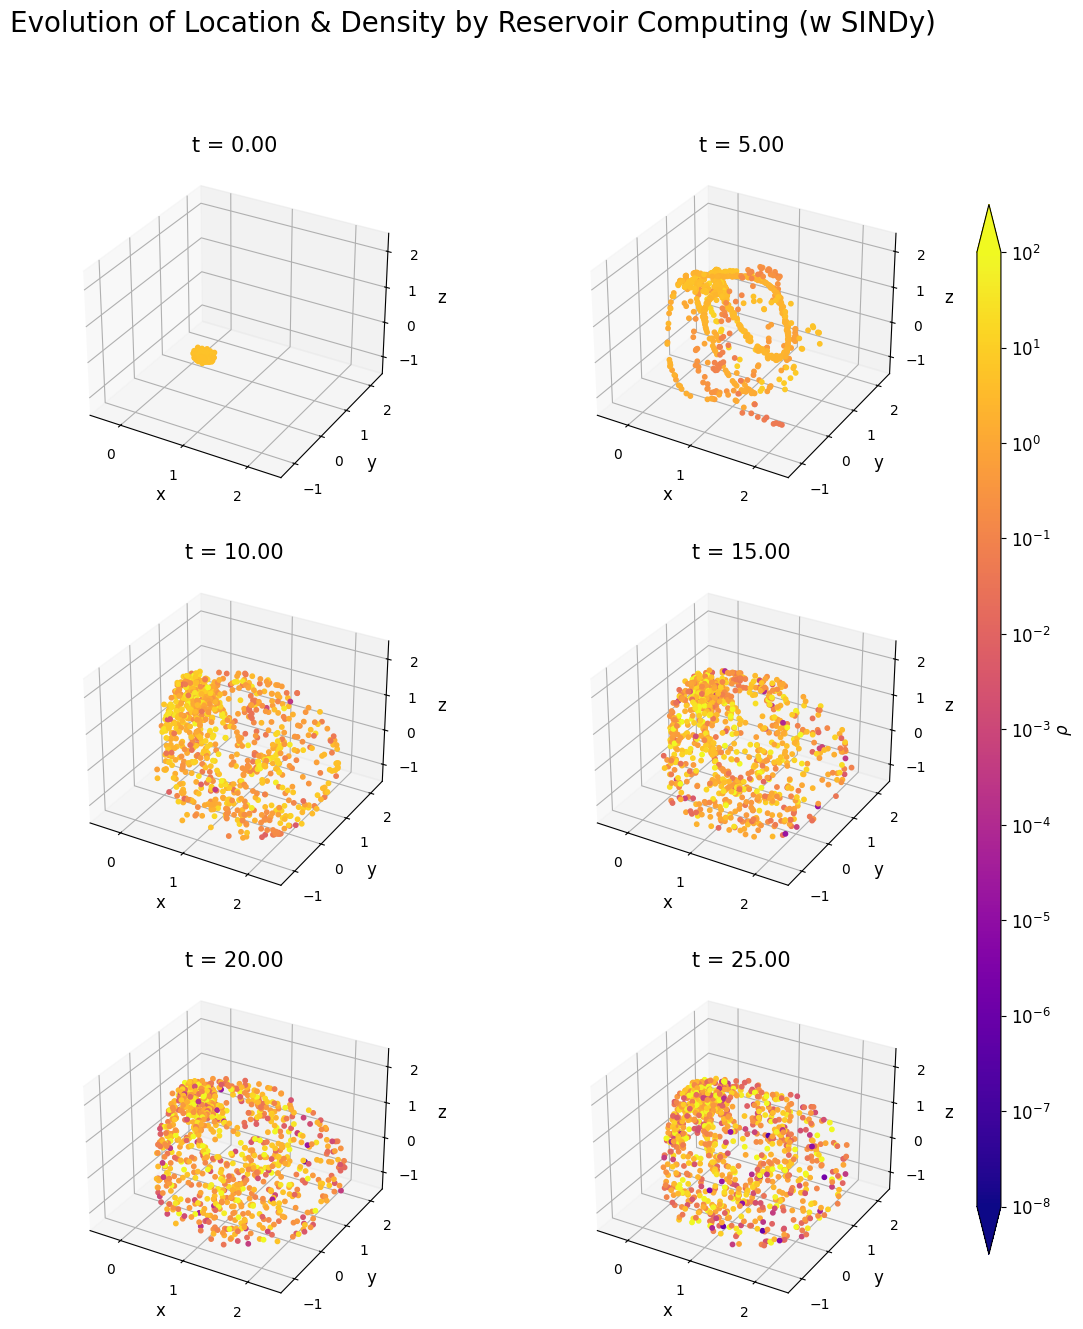

In [23]:
norm = colors.LogNorm(vmin=1e-8, vmax=1e2)

fig, ax = plt.subplots(3, 2, figsize=(12, 15), subplot_kw={'projection': '3d'})

for i in range(3):
    for j in range(2):
        sc = ax[i, j].scatter(data_RC[0, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[1, :, int(((forecast_time-2) / 5) * (2*i+j))], data_RC[2, :, int(((forecast_time-2) / 5) * (2*i+j))], c=rho_SINDy[int(((forecast_time-2) / 5) * (2*i+j)), :].T, cmap='plasma', norm=norm, s=10, alpha=1)
        ax[i, j].set_xticks(np.linspace(0, 2, 3))
        ax[i, j].set_yticks(np.linspace(-1, 2, 4))
        ax[i, j].set_zticks(np.linspace(-1, 2, 4))
        ax[i, j].set_xlim([-0.5, 2.5])
        ax[i, j].set_ylim([-1.5, 2.5])
        ax[i, j].set_zlim([-1.5, 2.5])
        ax[i, j].set_xlabel("x", fontsize=12)
        ax[i, j].set_ylabel("y", fontsize=12)
        ax[i, j].set_zlabel("z", fontsize=12)
        ax[i, j].set_title('t = %.2f' %t[int(((forecast_time-2) / 5) * (2*i+j))], fontsize=15)
        ax[i, j].grid()
        #ax[i, j].view_init(elev=15, azim=-60)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.logspace(-8, 2, 11), extend='both', aspect = 40)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\rho$', fontsize=12)

#plt.tight_layout()
plt.suptitle('Evolution of Location & Density by Reservoir Computing (w SINDy)', fontsize=20)
plt.savefig('Lorenz84_rho_SINDy.png', dpi=500)
plt.show()

In [24]:
x_nume = np.zeros((forecast_time, ensemble_size))
y_nume = np.zeros((forecast_time, ensemble_size))
z_nume = np.zeros((forecast_time, ensemble_size))
rho_nume_1 = np.zeros((forecast_time, ensemble_size))
G_nume = np.zeros((forecast_time-1, ensemble_size, dim, dim))

In [25]:
x_nume[0, :] = data_RC[0, :, 0]
y_nume[0, :] = data_RC[1, :, 0]
z_nume[0, :] = data_RC[2, :, 0]
rho_ini_nume = PDF(data_RC[:, :, 0], mu, cov)
rho_nume_1[0, :] = rho_ini_nume
ini_array_nume = np.vstack((data_RC[:, :, 0], rho_ini_nume))

ini_array_memb, x_memb_ini, y_memb_ini, z_memb_ini = ensemble(data_RC[:, :, 0], dx, memb, ensemble_size, mu, cov)

for i in range(forecast_time-1):

    # calculate X

    x_nume[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume, func_ODEs, dt)[0, :]
    y_nume[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume, func_ODEs, dt)[1, :]
    z_nume[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume, func_ODEs, dt)[2, :]
    rho_nume_1[i+1, :] = Solve_RK4(t[i:i+2], ini_array_nume, func_ODEs, dt)[3, :]
    ini_array_nume = np.array([x_nume[i+1, :], y_nume[i+1, :], z_nume[i+1, :], rho_nume_1[i+1, :]])

    # calculate G

    x_memb_fin = Solve_RK4(t[i:i+2], ini_array_memb, func_ODEs, dt)[0, :]
    y_memb_fin = Solve_RK4(t[i:i+2], ini_array_memb, func_ODEs, dt)[1, :]
    z_memb_fin = Solve_RK4(t[i:i+2], ini_array_memb, func_ODEs, dt)[2, :]
    rho_memb_fin = Solve_RK4(t[i:i+2], ini_array_memb, func_ODEs, dt)[3, :]

    x_memb_ini = x_memb_ini.reshape(ensemble_size, memb)
    y_memb_ini = y_memb_ini.reshape(ensemble_size, memb)
    z_memb_ini = z_memb_ini.reshape(ensemble_size, memb)
    x_memb_fin = x_memb_fin.reshape(ensemble_size, memb)
    y_memb_fin = y_memb_fin.reshape(ensemble_size, memb)
    z_memb_fin = z_memb_fin.reshape(ensemble_size, memb)

    X_memb_ini = np.array([x_memb_ini, y_memb_ini, z_memb_ini])
    X_memb_fin = np.array([x_memb_fin, y_memb_fin, z_memb_fin])

    for j in range(ensemble_size):
        if dim == 1:
            Ga = np.dot(X_memb_fin[:, j, :], X_memb_ini[:, j, :].transpose())
            Gb = np.linalg.inv(np.array([[np.dot(X_memb_ini[:, j, :], X_memb_ini[:, j, :].transpose())]]))
            G_nume[i, j, :, :] = np.dot(Ga, Gb)
        else:
            Ga = np.dot(X_memb_fin[:, j, :], X_memb_ini[:, j, :].transpose())
            Gb = np.linalg.inv(np.dot(X_memb_ini[:, j, :], X_memb_ini[:, j, :].transpose()))
            G_nume[i, j, :, :] = np.dot(Ga, Gb)

    ini_array_memb, x_memb_ini, y_memb_ini, z_memb_ini = ensemble(ini_array_nume[0:3, :], dx, memb, ensemble_size, mu, cov)

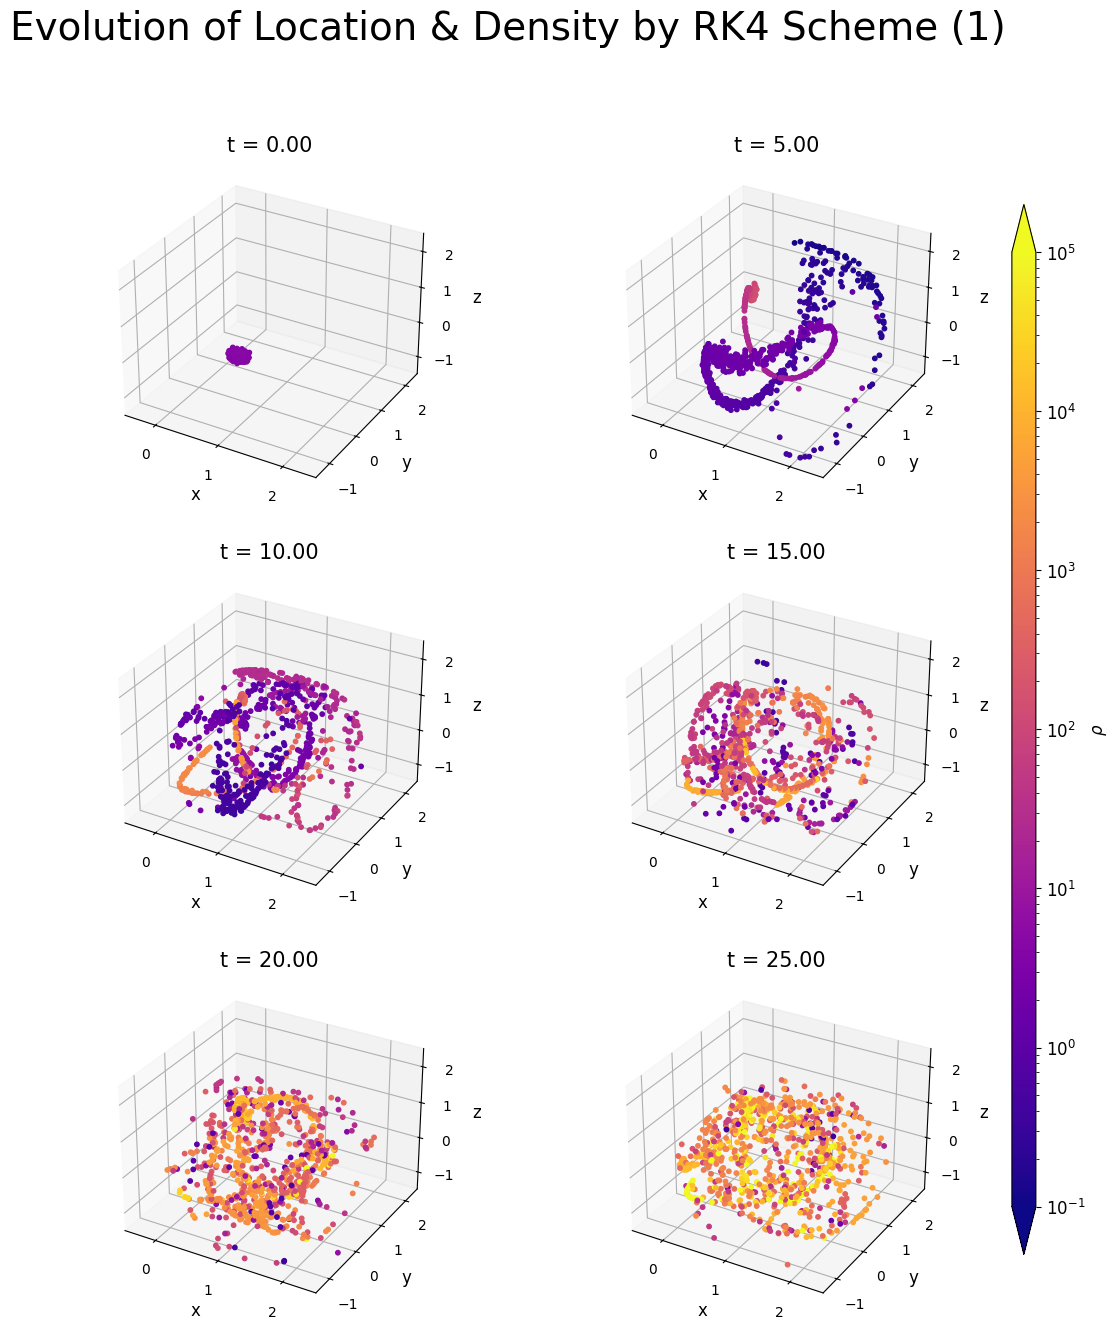

In [26]:
norm = colors.LogNorm(vmin=1e-1, vmax=1e5)

fig, ax = plt.subplots(3, 2, figsize=(12, 15), subplot_kw={'projection': '3d'})

for i in range(3):
    for j in range(2):
        sc = ax[i, j].scatter(x_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], y_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], z_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], c=rho_nume_1[int(((forecast_time-2) / 5) * (2*i+j)), :], cmap='plasma', norm=norm, s=10, alpha=1)
        ax[i, j].set_xticks(np.linspace(0, 2, 3))
        ax[i, j].set_yticks(np.linspace(-1, 2, 4))
        ax[i, j].set_zticks(np.linspace(-1, 2, 4))
        ax[i, j].set_xlim([-0.5, 2.5])
        ax[i, j].set_ylim([-1.5, 2.5])
        ax[i, j].set_zlim([-1.5, 2.5])
        ax[i, j].set_xlabel("x", fontsize=12)
        ax[i, j].set_ylabel("y", fontsize=12)
        ax[i, j].set_zlabel("z", fontsize=12)
        ax[i, j].set_title('t = %.2f' %t[int(((forecast_time-2) / 5) * (2*i+j))], fontsize=15)
        ax[i, j].grid()
        #ax[i, j].view_init(elev=15, azim=-60)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.logspace(-1, 5, 7), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\rho$', fontsize=12)

#plt.tight_layout()
plt.suptitle('Evolution of Location & Density by RK4 Scheme (1)', fontsize=28)
plt.savefig('Lorenz84_rho_RK4_1.png', dpi=500)
plt.show()

In [27]:
abs_detG_nume = abs(np.linalg.det(G_nume))
abs_detG_nume_avg = np.mean(abs_detG_nume, axis=0)
norm_abs_detG_nume = stats.zscore(abs_detG_nume, axis=0, ddof=1)

In [28]:
rho_nume_2 = np.zeros((forecast_time, ensemble_size))

rho_ini_nume = PDF(data_RC[:, :, 0], mu, cov)
rho_nume_2[0, :] = rho_ini_nume

for i in range(forecast_time-1):
    rho_nume_2[i+1, :] = rho_nume_2[i, :] / abs_detG_nume[i, :]

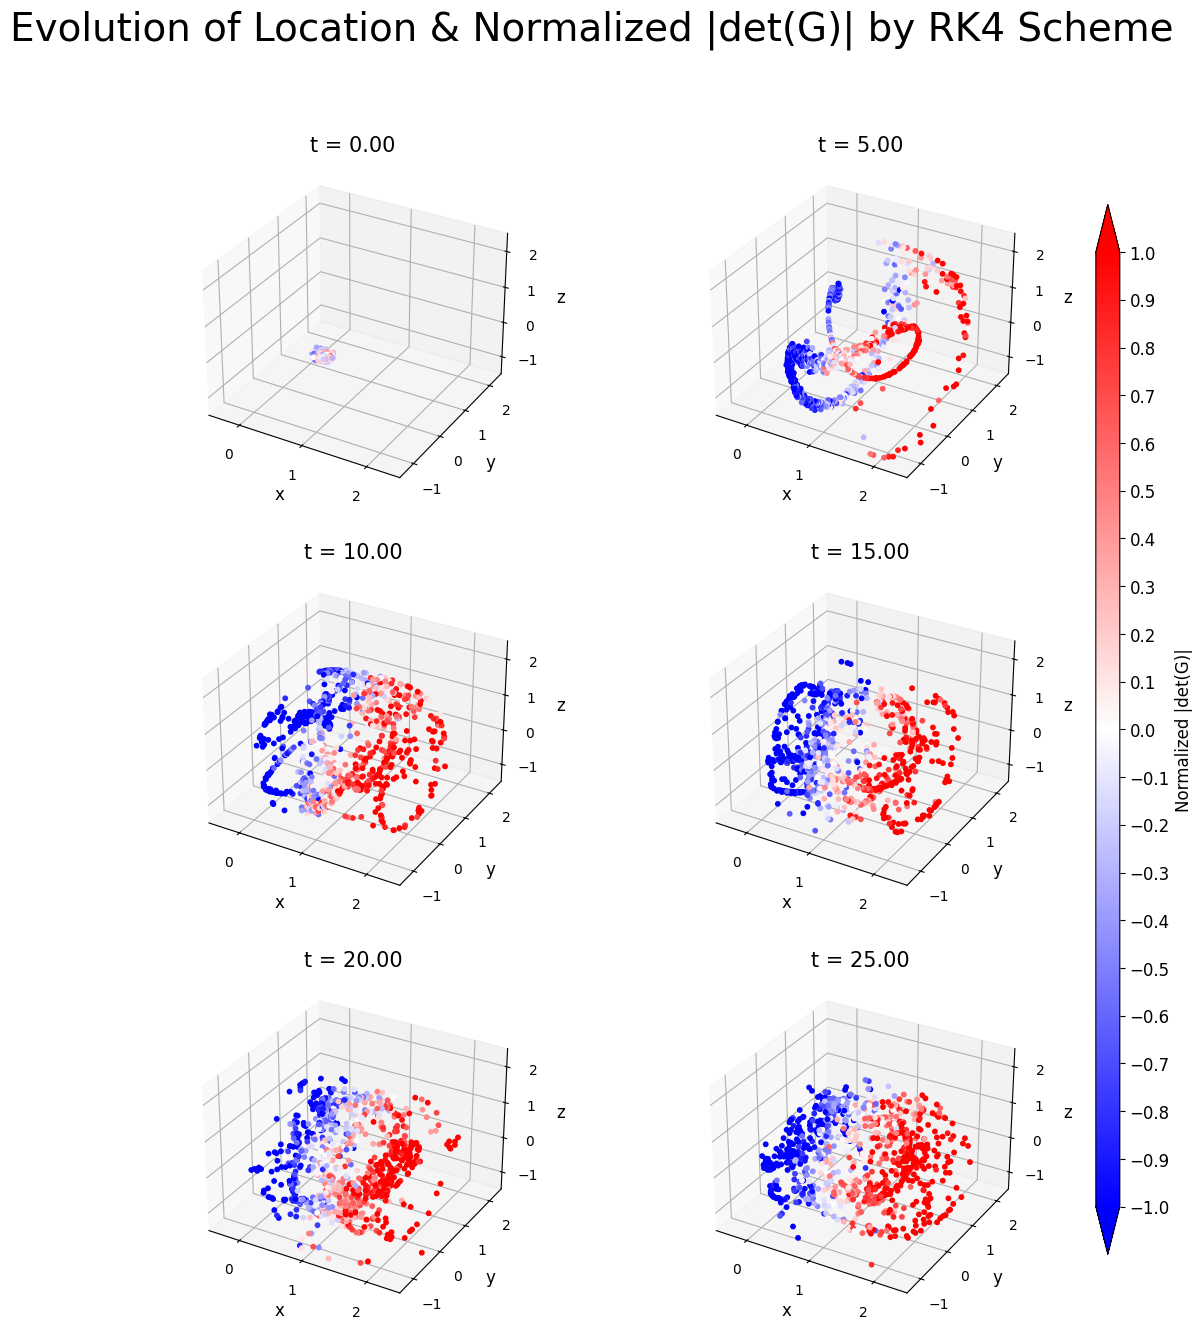

In [29]:
norm = plt.Normalize(-1, 1)

fig, ax = plt.subplots(3, 2, figsize=(12, 15), subplot_kw={'projection': '3d'})

for i in range(3):
    for j in range(2):
        sc = ax[i, j].scatter(x_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], y_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], z_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], c=norm_abs_detG_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], cmap='bwr', norm=norm, s=10, alpha=1)
        ax[i, j].set_xticks(np.linspace(0, 2, 3))
        ax[i, j].set_yticks(np.linspace(-1, 2, 4))
        ax[i, j].set_zticks(np.linspace(-1, 2, 4))
        ax[i, j].set_xlim([-0.5, 2.5])
        ax[i, j].set_ylim([-1.5, 2.5])
        ax[i, j].set_zlim([-1.5, 2.5])
        ax[i, j].set_xlabel("x", fontsize=12)
        ax[i, j].set_ylabel("y", fontsize=12)
        ax[i, j].set_zlabel("z", fontsize=12)
        ax[i, j].set_title('t = %.2f' %t[int(((forecast_time-2) / 5) * (2*i+j))], fontsize=15)
        ax[i, j].grid()
        #ax[i, j].view_init(elev=15, azim=-60)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.linspace(-1, 1, 21), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Normalized |det(G)|', fontsize=12)

#plt.tight_layout()
plt.suptitle('Evolution of Location & Normalized |det(G)| by RK4 Scheme', fontsize=28)
plt.savefig('Lorenz84_det(G)_RK4.png', dpi=500)
plt.show()

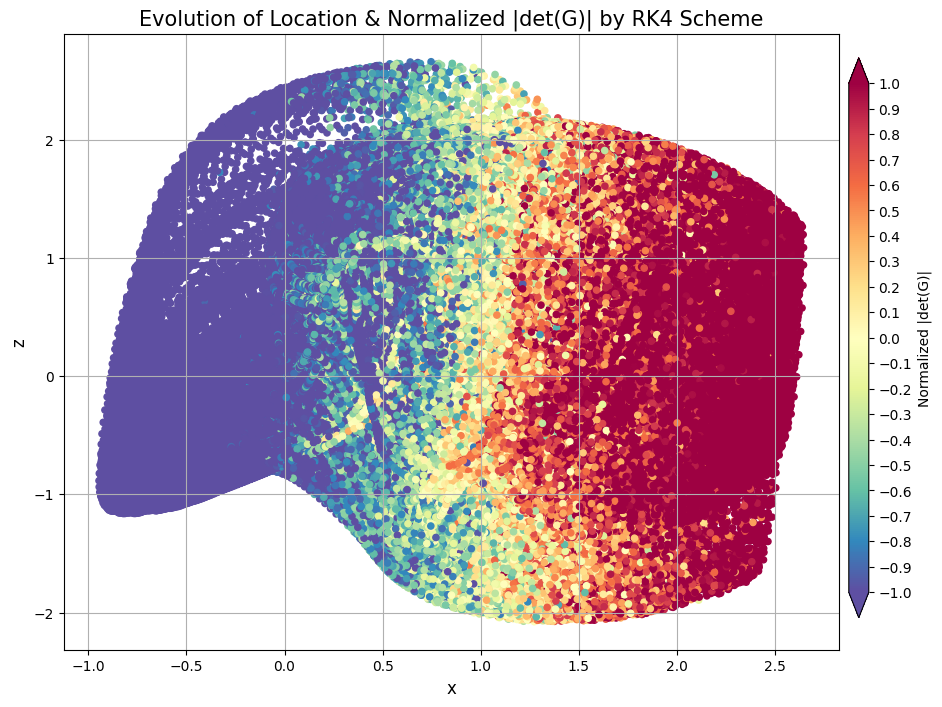

In [30]:
norm = plt.Normalize(-1, 1)

fig = plt.figure(figsize=(10, 8))

sc = plt.scatter(x_nume[:-1, :], z_nume[:-1, :], c=norm_abs_detG_nume, cmap='Spectral_r', norm=norm, s=20, alpha=1)
#plt.xticks(np.linspace(-0.5, 2.5, 7))
#plt.yticks(np.linspace(-1.5, 2.5, 9))
#plt.xlim([-0.5, 2.5])
#plt.ylim([-1.5, 2.5])
plt.xlabel("x", fontsize=12)
plt.ylabel("z", fontsize=12)
plt.title('Evolution of Location & Normalized |det(G)| by RK4 Scheme', fontsize=15)
plt.grid()

cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.linspace(-1, 1, 21), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Normalized |det(G)|', fontsize=10)

#plt.tight_layout()
plt.savefig('Lorenz84_xz_det(G)_RK4.png', dpi=500)
plt.show()

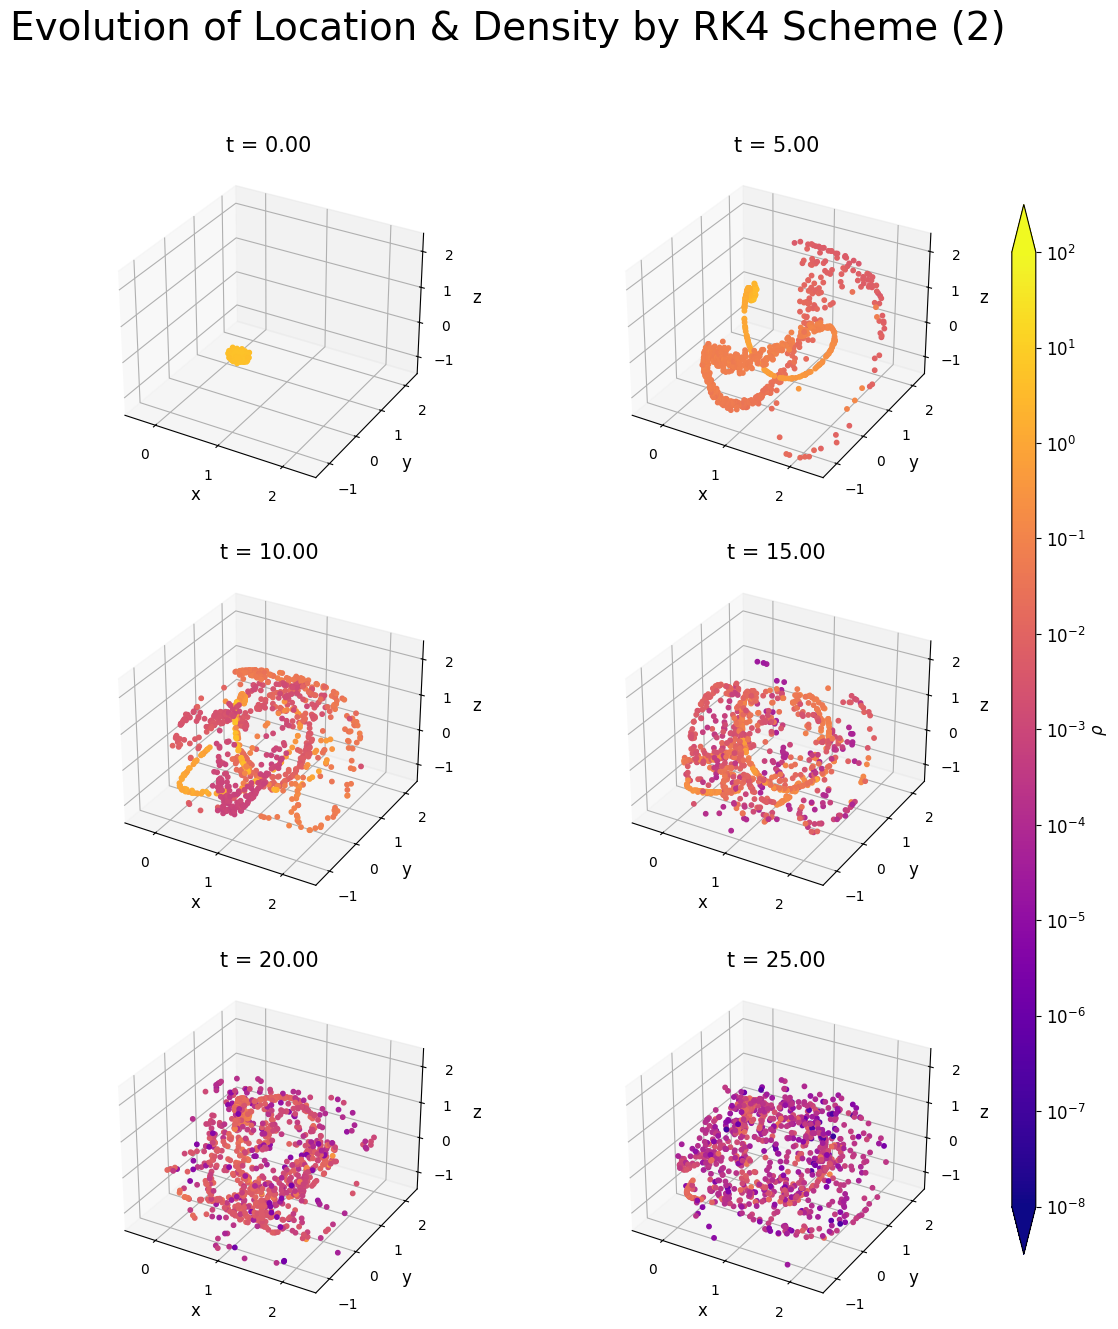

In [31]:
norm = colors.LogNorm(vmin=1e-8, vmax=1e2)

fig, ax = plt.subplots(3, 2, figsize=(12, 15), subplot_kw={'projection': '3d'})

for i in range(3):
    for j in range(2):
        sc = ax[i, j].scatter(x_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], y_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], z_nume[int(((forecast_time-2) / 5) * (2*i+j)), :], c=rho_nume_2[int(((forecast_time-2) / 5) * (2*i+j)), :], cmap='plasma', norm=norm, s=10, alpha=1)
        ax[i, j].set_xticks(np.linspace(0, 2, 3))
        ax[i, j].set_yticks(np.linspace(-1, 2, 4))
        ax[i, j].set_zticks(np.linspace(-1, 2, 4))
        ax[i, j].set_xlim([-0.5, 2.5])
        ax[i, j].set_ylim([-1.5, 2.5])
        ax[i, j].set_zlim([-1.5, 2.5])
        ax[i, j].set_xlabel("x", fontsize=12)
        ax[i, j].set_ylabel("y", fontsize=12)
        ax[i, j].set_zlabel("z", fontsize=12)
        ax[i, j].set_title('t = %.2f' %t[int(((forecast_time-2) / 5) * (2*i+j))], fontsize=15)
        ax[i, j].grid()
        #ax[i, j].view_init(elev=15, azim=-60)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #x,y,dx,dy
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.logspace(-8, 2, 11), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\rho$', fontsize=12)

#plt.tight_layout()
plt.suptitle('Evolution of Location & Density by RK4 Scheme (2)', fontsize=28)
plt.savefig('Lorenz84_rho_RK4_2.png', dpi=500)
plt.show()

C:\Users\kylec\AppData\Local\Temp\ipykernel_11084\661860718.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.83, 0.95])


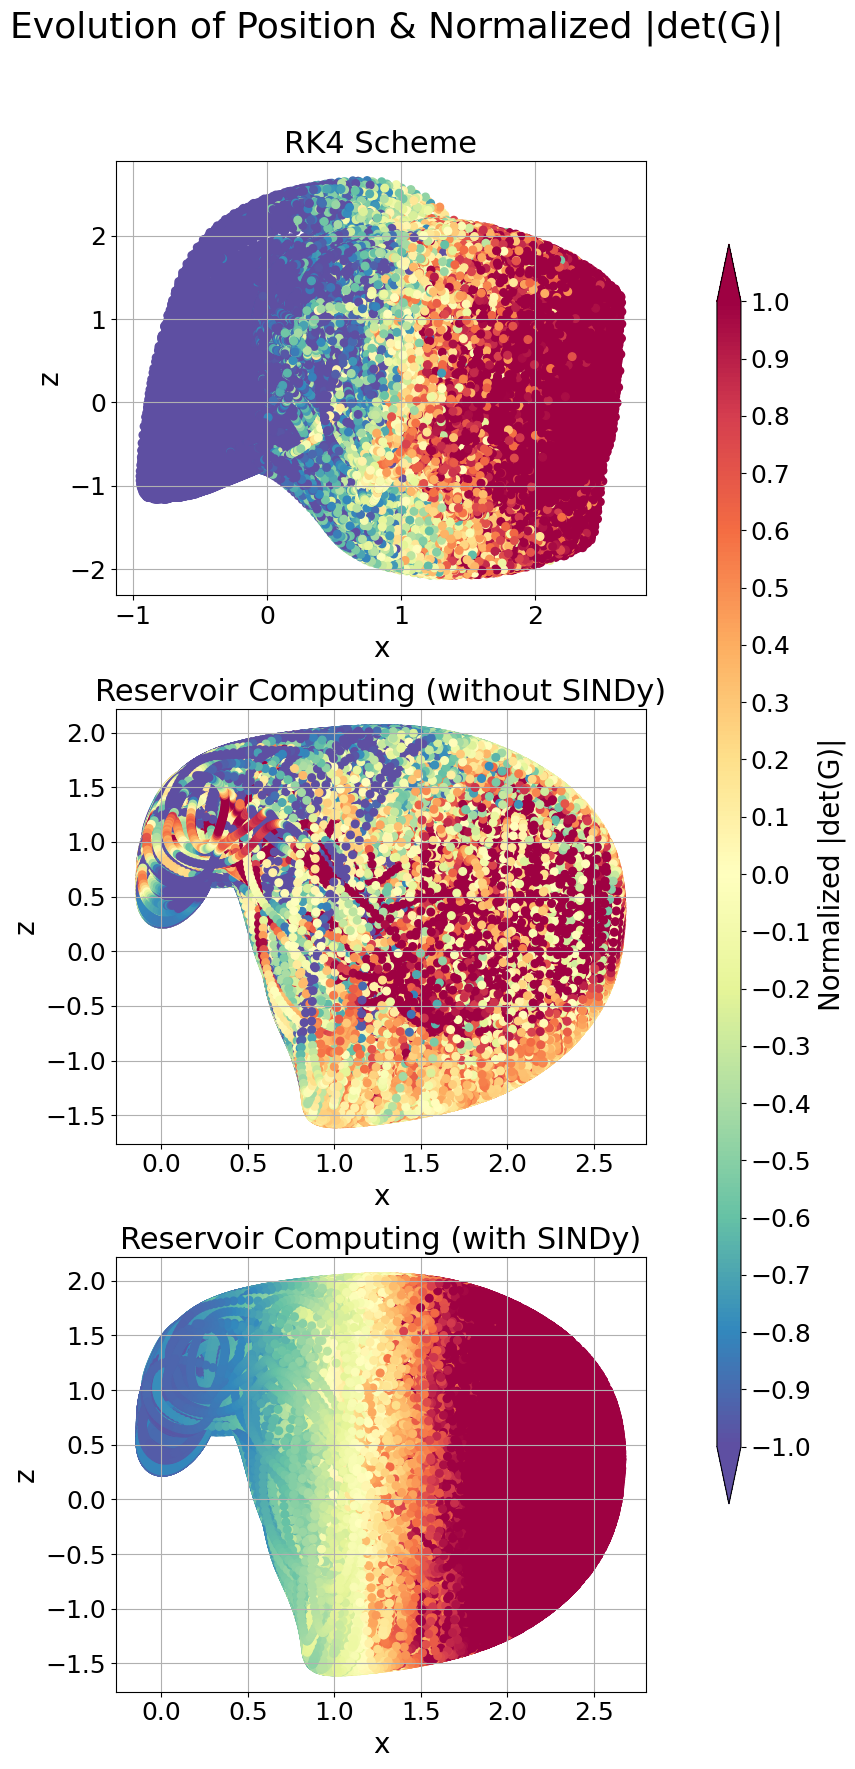

In [32]:
norm = plt.Normalize(-1, 1)

fig, ax = plt.subplots(3, 1, figsize=(8, 18))

sc = ax[0].scatter(x_nume[:-1, :], z_nume[:-1, :], c=norm_abs_detG_nume, cmap='Spectral_r', norm=norm, s=30, alpha=1)
ax[0].set_xlabel("x", fontsize=20)
ax[0].set_ylabel("z", fontsize=20)
ax[0].set_title('RK4 Scheme', fontsize=22)
ax[0].tick_params(axis='both', labelsize=18)
ax[0].grid()

sc = ax[1].scatter(data_RC[0, :, :-1], data_RC[2, :, :-1], c=norm_abs_detG_RC.T, cmap='Spectral_r', norm=norm, s=30, alpha=1)
ax[1].set_xlabel("x", fontsize=20)
ax[1].set_ylabel("z", fontsize=20)
ax[1].set_title('Reservoir Computing (without SINDy)', fontsize=22)
ax[1].tick_params(axis='both', labelsize=18)
ax[1].grid()

sc = ax[2].scatter(data_RC[0, :, :-1], data_RC[2, :, :-1], c=norm_abs_detG_SINDy.T, cmap='Spectral_r', norm=norm, s=30, alpha=1)
ax[2].set_xlabel("x", fontsize=20)
ax[2].set_ylabel("z", fontsize=20)
ax[2].set_title('Reservoir Computing (with SINDy)', fontsize=22)
ax[2].tick_params(axis='both', labelsize=18)
ax[2].grid()

cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = plt.colorbar(sc, orientation='vertical', cax=cbar_ax, ticks=np.linspace(-1, 1, 21), extend='both', aspect=40)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Normalized |det(G)|', fontsize=20)

plt.suptitle('Evolution of Position & Normalized |det(G)|', fontsize=26)

plt.tight_layout(rect=[0, 0, 0.83, 0.95])

plt.savefig('Lorenz84_xz_det(G).png', dpi=500)
plt.show()